In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [2]:
#The data is downloaded locally from Kaggle https://www.kaggle.com/c/nlp-getting-started/data
train_df = pd.read_csv('./data/train.csv',keep_default_na=False)
test_df = pd.read_csv('./data/test.csv',keep_default_na=False)

In [3]:
#get the first rows of the training data to get a sense of the structure of the data.
print(len(train_df))
train_df.head()

7613


,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#It looks like the data comprises an id primary key, keyword and location of the tweet which may be empty and the text of the tweet itself
train_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [5]:
#Based on the count of keywords the distribution is fairly uniform with few records without a keyword.
train_df.keyword.value_counts()

keyword
                         61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 222, dtype: int64

In [6]:
#Based on the count, a large amount of records are missing a location so that field can be dropped
train_df.location.value_counts()

location
                                2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: count, Length: 3342, dtype: int64

In [7]:
#Creating the x and y that will be fed to the model, in order to utilize the text vectorization layer the keyword is appended to the text field.
train_x_df = train_df["text"].str.cat(train_df["keyword"],sep=' ')
train_y_df = train_df["target"]

In [8]:
#Create a textvectorization layer and feeding it the text data to create a vocabulary for the model to use
text_vectorizer = keras.layers.TextVectorization(max_tokens=25000, output_mode='int', output_sequence_length=750)
text_vectorizer.adapt(train_x_df)

In [9]:
#The model will use the Twitter GloVe Embeddings found at https://nlp.stanford.edu/projects/glove/
vocabulary = text_vectorizer.get_vocabulary()
word_count = len(vocabulary) + 2
embedding_dim = 200


In [10]:
#Getting the embeddings for 200 dimensions from the downloaded text file and saving them in a dict
glove_embeddings = {}
with open("./data/glove.twitter.27B/glove.twitter.27B.200d.txt", encoding="utf8") as glove_file:
    for line in glove_file:
        word,coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs


In [11]:
#Creating an embedding matrix to load later in an embedding layer
glove_embeddings_matrix = np.zeros((word_count, embedding_dim))
i = 0
for word in vocabulary:
    glove_embedding = glove_embeddings.get(word)
    if glove_embedding is not None:
        glove_embeddings_matrix[i] = glove_embedding
    i += 1

In [12]:
#Create the embedding layer that the model will use
embedding_layer = keras.layers.Embedding(word_count, embedding_dim, trainable=False)
embedding_layer.build((1,))
embedding_layer.set_weights([glove_embeddings_matrix])

In [13]:
#Build an RNN model utilizing the vectorization + embedding layers. 2 LSTM layers are used before an output neuron gets the prediction. F1 score is used as a metric as the kaggle competition utilizes F1 score
model = keras.Sequential(
    [
        text_vectorizer,
        embedding_layer,
        keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)),
        keras.layers.Bidirectional(keras.layers.LSTM(16, dropout=0.25, recurrent_dropout=0.25)),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)
model.compile(optimizer=keras.optimizers.Adam(clipnorm=0.5), loss="binary_crossentropy", metrics=["f1_score","accuracy"])

In [14]:
model.fit(train_x_df,train_y_df,epochs=20)

Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.7058 - f1_score: 0.5943 - loss: 0.5846
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.7984 - f1_score: 0.6015 - loss: 0.4593
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.8080 - f1_score: 0.5910 - loss: 0.4345
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.8047 - f1_score: 0.5975 - loss: 0.4316
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.8121 - f1_score: 0.6018 - loss: 0.4192
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.8349 - f1_score: 0.6004 - loss: 0.3910
Epoch 7/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.8294 - f1_score: 0.6026 - loss: 0.3991
Epoch 8/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.8177 - f1_score: 0.6032 - loss: 0.4127
Epoch 9/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.8284 - f1_score: 0.6015 - loss: 0.3901
Epoch 10/20
238/238 ━━━━━━━━

In [35]:
#Creating a second model that is shallow and has more neurons
model2 = keras.Sequential(
    [
        text_vectorizer,
        embedding_layer,
        keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.25, recurrent_dropout=0.25)),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)
model2.compile(optimizer=keras.optimizers.Adam(clipnorm=0.5), loss="binary_crossentropy", metrics=["f1_score","accuracy"])

In [36]:
model2.fit(train_x_df,train_y_df,epochs=15)

Epoch 1/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 107s 440ms/step - accuracy: 0.7131 - f1_score: 0.6034 - loss: 0.5594
Epoch 2/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 105s 439ms/step - accuracy: 0.7989 - f1_score: 0.6124 - loss: 0.4489
Epoch 3/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.8120 - f1_score: 0.6013 - loss: 0.4204
Epoch 4/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 104s 437ms/step - accuracy: 0.8107 - f1_score: 0.5983 - loss: 0.4245
Epoch 5/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 105s 441ms/step - accuracy: 0.8195 - f1_score: 0.5984 - loss: 0.4048
Epoch 6/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 104s 438ms/step - accuracy: 0.8336 - f1_score: 0.5961 - loss: 0.3901
Epoch 7/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 104s 437ms/step - accuracy: 0.8333 - f1_score: 0.6105 - loss: 0.3828
Epoch 8/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 105s 439ms/step - accuracy: 0.8433 - f1_score: 0.5978 - loss: 0.3668
Epoch 9/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.8408 - f1_score: 0.6069 - loss: 0.3641
Epoch 10/15
238/238

In [33]:
#Creating a model that is deeper and has more neurons
model3 = keras.Sequential(
    [
        text_vectorizer,
        embedding_layer,
        keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)),
        keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)),
        keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)),
        keras.layers.Bidirectional(keras.layers.LSTM(16, dropout=0.25, recurrent_dropout=0.25)),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)
model3.compile(optimizer=keras.optimizers.Adam(clipnorm=0.5), loss="binary_crossentropy", metrics=["f1_score","accuracy"])

In [34]:
model3.fit(train_x_df,train_y_df,epochs=15)

Epoch 1/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 213s 867ms/step - accuracy: 0.7036 - f1_score: 0.6003 - loss: 0.5801
Epoch 2/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 196s 826ms/step - accuracy: 0.7974 - f1_score: 0.6011 - loss: 0.4572
Epoch 3/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 197s 828ms/step - accuracy: 0.7992 - f1_score: 0.6077 - loss: 0.4409
Epoch 4/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.8178 - f1_score: 0.5939 - loss: 0.4174
Epoch 5/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 225s 947ms/step - accuracy: 0.8132 - f1_score: 0.6012 - loss: 0.4270
Epoch 6/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8304 - f1_score: 0.5931 - loss: 0.3951
Epoch 7/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8279 - f1_score: 0.5930 - loss: 0.3899
Epoch 8/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 235s 986ms/step - accuracy: 0.8464 - f1_score: 0.6051 - loss: 0.3730
Epoch 9/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 223s 938ms/step - accuracy: 0.8424 - f1_score: 0.5970 - loss: 0.3677
Epoch 10/15
238/238 ━━━━━━━━

In [63]:
#From the loss and accuracy viewpoint both models 2 and 3 are similar in terms of performance. Therefore, both models are valid candidates for the prediction step. However, as model 2 has the better f1 score this is the model that will be selected
test_x_df = test_df["text"].str.cat(test_df["keyword"],sep=' ')
test_id_df = test_df["id"]

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step


(array([721., 454., 280., 244., 191., 149., 127., 122., 152., 823.]),
 array([0.00457749, 0.10411847, 0.20365945, 0.30320042, 0.4027414 ,
        0.50228238, 0.60182339, 0.70136434, 0.80090535, 0.9004463 ,
        0.9999873 ]),
 <BarContainer object of 10 artists>)

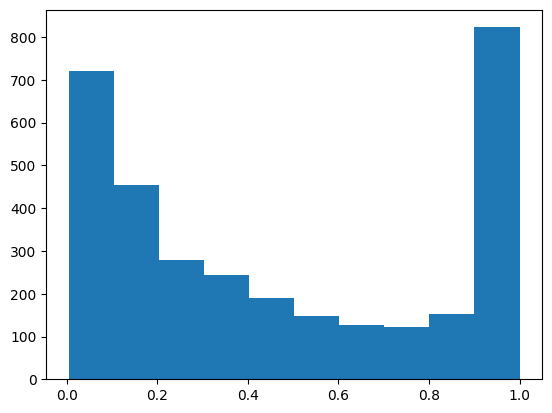

In [64]:
plt.hist(model2.predict(test_x_df))

In [65]:
predictions = model2.predict(test_x_df)

results_df = pd.DataFrame({"id":test_id_df,"target":[1 if i>0.5 else 0 for i in predictions]})

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step


In [66]:
results_df.head(15)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [67]:
results_df.to_csv("./data/submission.csv",index=False)

In [69]:
#In conclusion, based on the experiment above more layer does not necessarily result in a better RNN model. Adding more neurons to a shallow network appears to score better.
#References
#Glove Embeddings: Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.
#Glove Twitter Embeddings: https://nlp.stanford.edu/data/glove.twitter.27B.zip
#Kaggle NLP Tweet Competition: https://www.kaggle.com/competitions/nlp-getting-started/data
#Keras Using pre-trained word embeddings Tutorial: https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings